In [1]:
import pandas as pd
import numpy as np
from scipy.stats import qmc
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
sheets = pd.ExcelFile('hist_data.xlsm').sheet_names
stocks = pd.DataFrame()
for sheet in sheets:
    temp = pd.read_excel('hist_data.xlsm', sheet_name = sheet)
    if sheet != 'SofrCurve':
        stocks['Date'] = temp['Date']
        stocks[sheet] = temp['Adj Close']
    else:
        swap = temp

stocks.set_index('Date', inplace = True)

In [3]:
def plot(change, var, title):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    plt.title(title)
    plt.hist(change, bins = 50)
    plt.axvline(x = -var, color = 'r')
    ax.xaxis.set_major_formatter('${x:1,.0f}');

# Initial Value

In [4]:
VaR_percentile = 5

### Stock

In [5]:
# initial value of holdings
stocks_holdings_value = np.array([1e6] * 4)

# compute returns
for col in stocks.columns:
    stocks[f'{col}_ret'] = stocks[col].pct_change()

stocks_price = stocks[[col for col in stocks.columns if 'ret' not in col]].iloc[-1].to_numpy()
stock_port_value = stocks_holdings_value * stocks_price # porfolio value
share_holdings = stocks_holdings_value / stocks_price # shares owned

### Swap

In [6]:
swap_notional = 100e6
fixed_leg_ir = 0.042
swap_fixed_interest = swap_notional * fixed_leg_ir

# formatting df
sofr = swap.T.iloc[2:]
sofr.columns = swap['T'].unique()

# filter for 1-10Y rates
sofr = sofr[[i for i in range(1, 11)]]

DF = sofr.copy()

# compute disocunt factors
for i in range(len(DF.columns)):
    DF[DF.columns[i]] = np.exp(- DF[DF.columns[i]].astype(float) * (i + 1))


def PV_payer_swap(discount_factors):
    # payer swap PV = notional + (- notional * tenor DF - discounted CF of fixed leg)
    payer_swap_PV  = swap_notional + (- swap_notional * discount_factors[9] - swap_fixed_interest * discount_factors.sum())

    return payer_swap_PV

# compute current value of swap
today_DF = DF.iloc[-1, ].to_numpy()
payer_swap_today = PV_payer_swap(today_DF)

# Parametric VaR

### Stock

In [7]:
# stock returns
stocks_rets = stocks[[col for col in stocks.columns if 'ret' in col]].dropna()

# current stock price
curr_stocks_price = stocks[[col for col in stocks.columns if 'ret' not in col]].iloc[-1].to_numpy()

# stock returns statistics
stocks_mean = stocks_rets.mean(axis = 0)
stocks_std = stocks_rets.std(axis = 0)
stocks_cov = stocks[[col for col in stocks.columns if 'ret' in col]].iloc[1:, ].cov().to_numpy()

# parametric stock statistics
Para_stock_mean = (stocks_mean * stocks_holdings_value).sum()
Para_stock_std = np.sqrt(np.matmul(np.matmul(stocks_holdings_value, stocks_cov), stocks_holdings_value.T))

### Swap


In [8]:
bp_change = 0.0001

n_days = len(sofr)
n_tenors = len(sofr.columns)
# payer_change = np.zeros(n_days * n_tenors)

payer_change = sofr.copy()

# for each day
for day in range(n_days):

    # for each tenor
    for tenor in range(n_tenors):

        # filter for rates on that day
        sofr_today = sofr.iloc[day, ].to_numpy()

        # compute discount factors
        DF = pd.DataFrame(sofr_today).T

        for j in range(len(DF.columns)):
            DF[DF.columns[j]] = np.exp(- DF[DF.columns[j]].astype(float) * (j + 1))
        DF = DF.to_numpy()[0]

        # add 1bp to the rate for that tenor
        sofr_today[tenor] = sofr_today[tenor] + bp_change

        # reduce prior tenor by 1bp
        sofr_today[tenor - 1] = sofr_today[tenor - 1] - bp_change

        # compute new discount factors
        new_DF = pd.DataFrame(sofr_today).T

        for j in range(len(new_DF.columns)):
            new_DF[new_DF.columns[j]] = np.exp(- new_DF[new_DF.columns[j]].astype(float) * (j + 1))
        new_DF = new_DF.to_numpy()[0]

        # compute change in swap value
        payer_change.iloc[day, tenor] = PV_payer_swap(new_DF) - PV_payer_swap(DF)

In [9]:
payer_change = np.zeros(n_tenors)

for tenor in range(n_tenors):

    # filter for rates on that day
    sofr_today = sofr.iloc[-1, ].to_numpy()

    # add 1bp to the rate for that tenor
    sofr_today[tenor] = sofr_today[tenor] + bp_change

    # reduce prior tenor by 1bp
    sofr_today[tenor - 1] = sofr_today[tenor - 1] - bp_change

    # compute new discount factors
    new_DF = pd.DataFrame(sofr_today).T

    for j in range(len(new_DF.columns)):
        new_DF[new_DF.columns[j]] = np.exp(- new_DF[new_DF.columns[j]].astype(float) * (j + 1))
    new_DF = new_DF.to_numpy()[0]

    # compute change in swap value
    payer_change[tenor] = PV_payer_swap(new_DF) - payer_swap_today

In [10]:
Para_swap_mean = payer_swap_today + payer_change.mean()
Para_swap_cov = np.cov(payer_change)
Para_swap_std = np.sqrt(payer_swap_today * Para_swap_cov * payer_swap_today)

In [11]:
z = norm.ppf(VaR_percentile / 100)

Para_VaR = abs(Para_stock_mean - z * Para_stock_std)
print('Stock 5% VaR:', Para_VaR)

Stock 5% VaR: 88802.9161372851


# Monte Carlo

In [12]:
def simulate(dimension, power):
    simulation = qmc.Sobol(d = dimension, scramble = False)
    simulation = simulation.random_base2(m = power)
    simulation = np.delete(simulation, 0, axis = 0)

    return simulation

# Simulate stocks returns
stock_simulation = simulate(4, 18)

# compute correlation matrix and cholesky decomposition to generate correlated samples
stock_corr_matrix = stocks_rets.corr().to_numpy()
stock_cholesky = np.linalg.cholesky(stock_corr_matrix)

# convert uniform normal to normal
stock_simulated_returns = norm.ppf(stock_simulation, loc = stocks_mean, scale = stocks_std)

# compute correlated samples
stock_simulated_returns = np.matmul(stock_cholesky, stock_simulated_returns.T).T
stock_simulated_returns.shape

# Simulate SOFR changes
sofr_simulation = simulate(len(sofr.columns) , 18)

sofr_delta = sofr.diff().dropna()
sofr_mean = sofr_delta.mean(axis = 0)
sofr_std = sofr_delta.std(axis = 0)

# compute correlation matrix and cholesky decomposition to generate correlated samples
sofr_corr_matrix = sofr_delta.corr(numeric_only = False).to_numpy()
sofr_cholesky = np.linalg.cholesky(sofr_corr_matrix)

# convert uniform normal to normal
sofr_simulated = norm.ppf(sofr_simulation, loc = sofr_mean, scale = sofr_std)

# compute correlated samples
sofr_simulated = np.matmul(sofr_cholesky, sofr_simulated.T).T

Full Revaluation SOFR Swap 95% VaR: $1,104,831.87


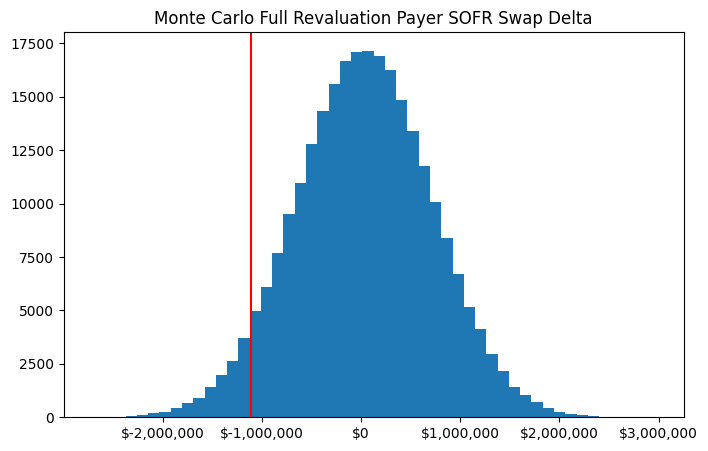

In [13]:
# today's sofr
sofr_today = sofr.iloc[-1, ].to_numpy()

# apply changes in risk factors to today's sofr
new_DF = pd.DataFrame(sofr_today + sofr_simulated)

# compute discount factor for each time prriod
for i in range(len(new_DF.columns)):
    new_DF[new_DF.columns[i]] = np.exp(- new_DF[new_DF.columns[i]].astype(float) * (i + 1))

new_DF = new_DF.to_numpy()

n = len(sofr_simulated)
MC_full_reval_payer = np.zeros(n)

# compute payer swap value for each risk factor
for i in range(n):
    MC_full_reval_payer[i] = PV_payer_swap(new_DF[i])

# calculate change in swap value
MC_full_reval_payer = MC_full_reval_payer - payer_swap_today

MC_full_reval_payer_VaR = abs(np.percentile(MC_full_reval_payer, VaR_percentile))

print(f'Full Revaluation SOFR Swap 95% VaR: ${round(MC_full_reval_payer_VaR, 2):,}')
plot(MC_full_reval_payer, MC_full_reval_payer_VaR, 'Monte Carlo Full Revaluation Payer SOFR Swap Delta')

### Stock

#### Full Revaluation

Full Revaluation Stock 95% VaR: $84,004.91


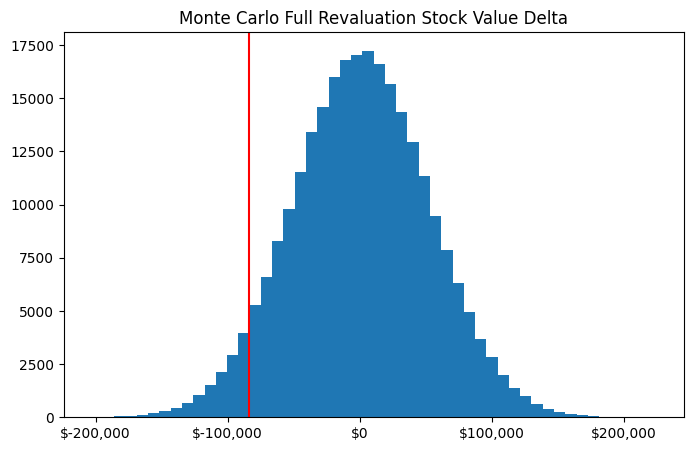

In [14]:
# apply risk factor to today's prices to get new stock prices
MC_full_reval_prices = curr_stocks_price * (1 + stock_simulated_returns)

# multiply shares with stock price to get new stock portfolio value
MC_full_reval_stock_port = share_holdings * MC_full_reval_prices

# subtract new stock portfolio value from current value 
MC_full_reval_stock_port_change = (MC_full_reval_stock_port - stocks_holdings_value).sum(axis = 1)

# 5% VaR for stock
MC_full_reval_VaR = abs(np.percentile(MC_full_reval_stock_port_change, VaR_percentile))

print(f'Full Revaluation Stock 95% VaR: ${round(MC_full_reval_VaR, 2):,}')

plot(MC_full_reval_stock_port_change, MC_full_reval_VaR,'Monte Carlo Full Revaluation Stock Value Delta' )

#### Risk-Based

Risk-Based Stock 95% VaR: $84,004.91


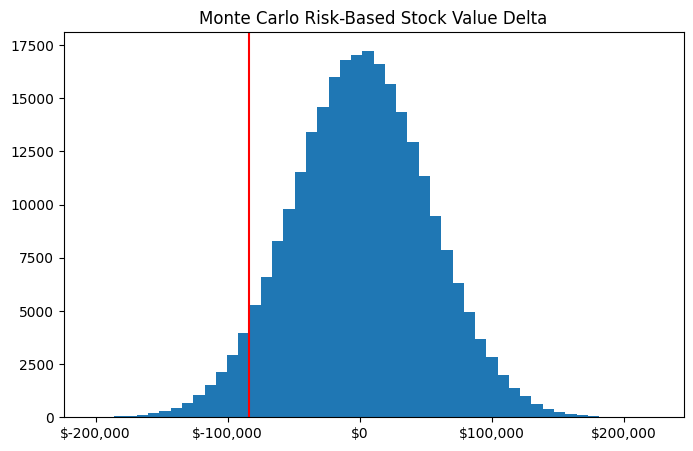

In [15]:
# calculate change as a result of risk factor to the portfolio value
MC_risk_based_stock_port_change = stocks_holdings_value * stock_simulated_returns 
MC_risk_based_stock_port_change = MC_risk_based_stock_port_change.sum(axis = 1)

# 5% VaR for stock
MC_risk_based_VaR = abs(np.percentile(MC_risk_based_stock_port_change, VaR_percentile))

print(f'Risk-Based Stock 95% VaR: ${round(MC_risk_based_VaR, 2):,}')

plot(MC_risk_based_stock_port_change, MC_risk_based_VaR, 'Monte Carlo Risk-Based Stock Value Delta')

### Overall

#### Full Revaluation

Full Revaluation 95% VaR: $1,183,072.29


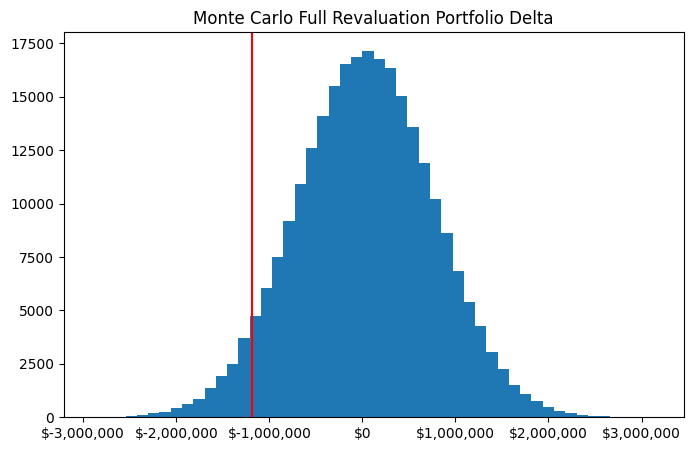

In [16]:
# sum portfolio changes due to swap and stock
MC_full_reval_portfolio_change = MC_full_reval_payer + MC_full_reval_stock_port_change

# 5th percentile for VaR
MC_full_reval_portfolio_VaR = abs(np.percentile(MC_full_reval_portfolio_change, VaR_percentile))
print(f'Full Revaluation 95% VaR: ${round(MC_full_reval_portfolio_VaR, 2):,}')

plot(MC_full_reval_portfolio_change, MC_full_reval_portfolio_VaR, 'Monte Carlo Full Revaluation Portfolio Delta')

# Historical

### Swap

Full Revaluation Swap 95% VaR: $962,541.68


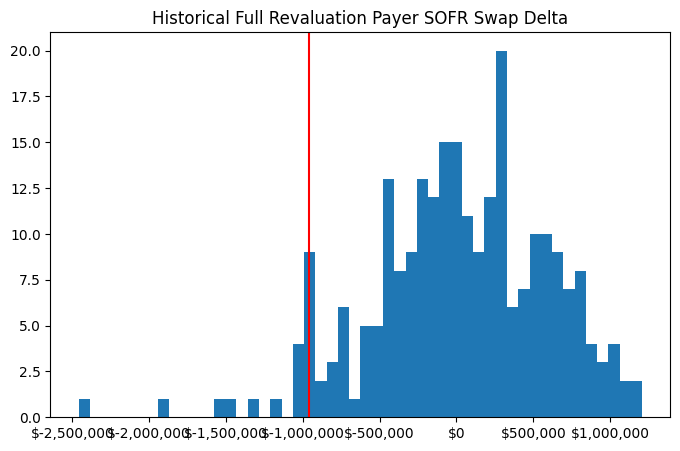

In [17]:
# sofr rate today
sofr_today = sofr.iloc[-1, ].to_numpy()

# apply historical rate changes to today's rates
new_DF = pd.DataFrame(sofr_today + sofr_delta.to_numpy())

# compute new discount factors for each period
for i in range(len(new_DF.columns)):
    new_DF[new_DF.columns[i]] = np.exp(- new_DF[new_DF.columns[i]].astype(float) * (i + 1))

new_DF = new_DF.to_numpy()

n = len(sofr_delta)
HS_full_reval_payer = np.zeros(n)

# compute payer swap value for each risk factor
for i in range(n):
    HS_full_reval_payer[i] = PV_payer_swap(new_DF[i])

# calculate change in value of swap
HS_full_reval_payer = HS_full_reval_payer - payer_swap_today
HS_full_reval_payer_VaR = abs(np.percentile(HS_full_reval_payer, VaR_percentile))

print(f'Full Revaluation Swap 95% VaR: ${round(HS_full_reval_payer_VaR, 2):,}')
plot(HS_full_reval_payer, HS_full_reval_payer_VaR, 'Historical Full Revaluation Payer SOFR Swap Delta')

### Stock

#### Full Revaluation

Full Revaluation Stock 95% VaR: $82,934.71


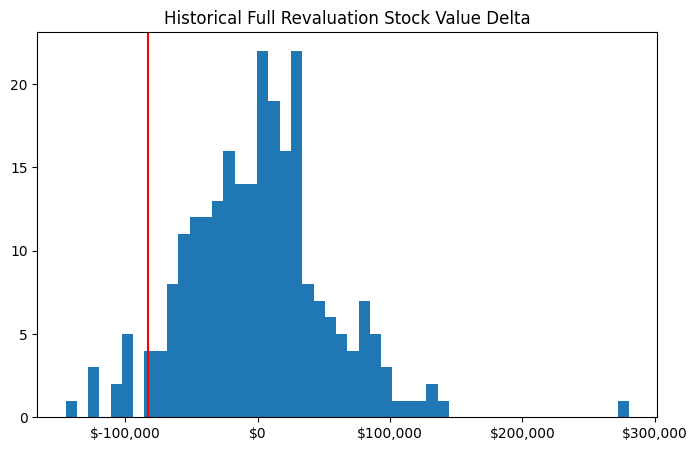

In [18]:
# apply risk factor to today's prices to get new stock prices
HS_full_reval_prices = stocks_price * (1 + stocks_rets)

# multiply shares with stock price to get new stock portfolio value
HS_full_reval_stock_port = share_holdings * HS_full_reval_prices

# subtract new stock portfolio value from current value 
HS_full_reval_stock_port_change = (HS_full_reval_stock_port - stocks_holdings_value).sum(axis = 1) 
HS_full_reval_VaR = abs(np.percentile(HS_full_reval_stock_port_change, VaR_percentile))

print(f'Full Revaluation Stock 95% VaR: ${round(HS_full_reval_VaR, 2):,}')
plot(HS_full_reval_stock_port_change, HS_full_reval_VaR, 'Historical Full Revaluation Stock Value Delta')

#### Risk-Based

Full Revaluation Stock 95% VaR: $82,934.71


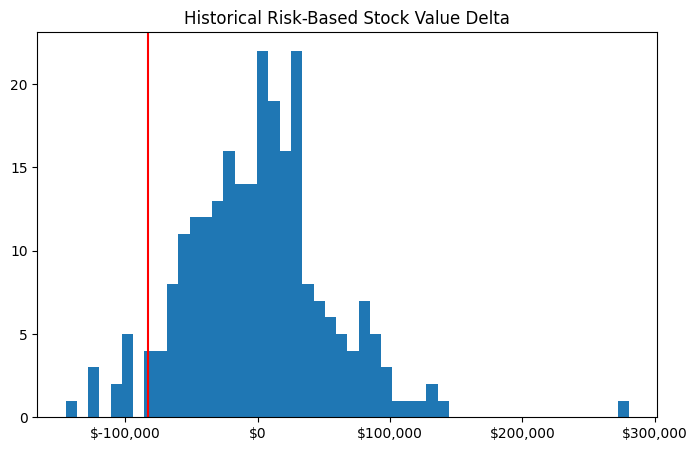

In [19]:
HS_risk_based_stock_port_change = stocks_holdings_value * stocks_rets
HS_risk_based_stock_port_change = HS_risk_based_stock_port_change.sum(axis = 1)

HS_risk_based_VaR = abs(np.percentile(HS_risk_based_stock_port_change, VaR_percentile))

print(f'Full Revaluation Stock 95% VaR: ${round(HS_full_reval_VaR, 2):,}')
plot(HS_risk_based_stock_port_change, HS_risk_based_VaR, 'Historical Risk-Based Stock Value Delta')

### Overall

Full Revaluation Portfolio 95% VaR: $966,173.22


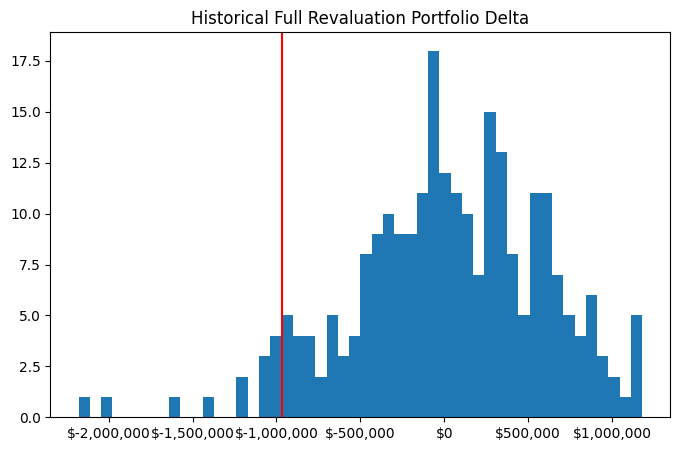

In [20]:
# sum portfolio changes due to swap and stock
HS_full_reval_portfolio_change = HS_full_reval_payer + HS_full_reval_stock_port_change

# 5th percentile for VaR
HS_full_reval_portfolio_VaR = abs(np.percentile(HS_full_reval_portfolio_change, VaR_percentile))

print(f'Full Revaluation Portfolio 95% VaR: ${round(HS_full_reval_portfolio_VaR, 2):,}')
plot(HS_full_reval_portfolio_change, HS_full_reval_portfolio_VaR, 'Historical Full Revaluation Portfolio Delta')